<a href="https://colab.research.google.com/github/joaogabrielanuto/quant-traders/blob/under-construction/estudos/codigo_joao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# ***Backtest Cruzamento mm com filtro "mm longa"***
---

## **1. Importação das Libs**

In [2]:
#!pip install mplfinance

  Using cached mplfinance-0.12.9b7-py3-none-any.whl (73 kB)


In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import mplfinance as mpf

---

## **2. Importação dos dados financeiros**

In [2]:
df = yf.download('^BVSP', interval='1D', start='2005-01-01')

[*********************100%***********************]  1 of 1 completed


In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,26193.0,26492.0,25671.0,25722.0,25722.0,0
2005-01-04,25722.0,25873.0,24791.0,24848.0,24848.0,0
2005-01-05,24859.0,25001.0,24523.0,24692.0,24692.0,0
2005-01-06,24695.0,24808.0,24250.0,24367.0,24367.0,0
2005-01-07,24376.0,24874.0,24376.0,24747.0,24747.0,0


---

## **3. Criar médias necessárias"**

In [4]:
mm_rapida = 20
mm_lenta = 50
mm_filtro = 200

df['Valor_medio'] = (df['Open'] + df['High'] + df['Low'] + df['Close'])/4
df['Media_rapida'] = df['Valor_medio'].rolling(mm_rapida).mean()
df['Media_lenta'] = df['Valor_medio'].rolling(mm_lenta).mean()
df['mm_filtro'] = df['Valor_medio'].rolling(mm_filtro).mean()

**Nota:** Vamos plotar um pedaço do nosso ativo para verificar como o indicador está se comportando

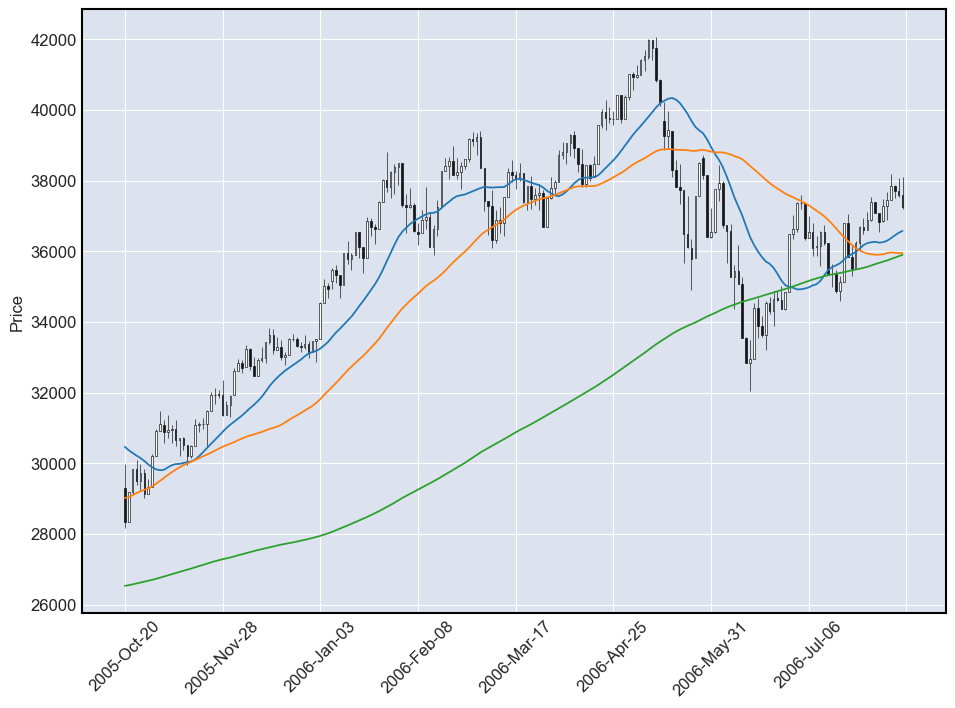

In [5]:
df_plot = df.iloc[200:400]
plot_mm_rapida = mpf.make_addplot(df_plot['Media_rapida'])
plot_mm_lenta = mpf.make_addplot(df_plot['Media_lenta'])
plot_mm_filtro = mpf.make_addplot(df_plot['mm_filtro'])
mpf.plot(df_plot, type='candle', addplot=[plot_mm_rapida, plot_mm_lenta, plot_mm_filtro], figscale=1.50)

---

## **4. Backtest**

**Regras do nosso tradingsytem:**

*OBS: Apenas trades de compra*

**Entrada:**
* Média rápida cruzar acima da média lenta
* Estar acima da média filtro

**Saída:**
* Média rápida cruzar abaixo da média lenta

In [13]:
position = 0
dict_precos = {'entrada':[], 'data_ent':[], 'preco_ent':[], 'saida':[], 'data_sai':[], 'preco_sai':[]}

for i in range(len(df)):

    if (position==0) and (df['Media_rapida'].iloc[i] > df['Media_lenta'].iloc[i]) and (df['Media_rapida'].shift(1).iloc[i] < df['Media_lenta'].shift(1).iloc[i]) \
    and (df['Close'][i] > (df['mm_filtro'][i])):
        dict_precos['entrada'].append('compra')
        dict_precos['data_ent'].append(df.index[i])
        dict_precos['preco_ent'].append(df.Close[i])
        position=1

    if (position==1) and (df['Media_rapida'].iloc[i] < df['Media_lenta'].iloc[i]) and (df['Media_rapida'].shift(1).iloc[i] > df['Media_lenta'].shift(1).iloc[i]):
        dict_precos['saida'].append('realiza')
        dict_precos['data_sai'].append(df.index[i])
        dict_precos['preco_sai'].append(df.Close[i])
        position=0
        
df_results = pd.DataFrame.from_dict(dict_precos, orient='index').transpose()
df_results = df_results.set_index('data_ent')
df_results['com filtro mm200'] = (df_results.preco_sai/df_results.preco_ent)
df_results.head()

,entrada,preco_ent,saida,data_sai,preco_sai,com filtro mm200
data_ent,,,,,,
2006-04-06,compra,39285.0,realiza,2006-06-01,37748.0,0.960876
2006-07-25,compra,36681.0,realiza,2006-09-14,36154.0,0.985633
2006-10-17,compra,38898.0,realiza,2007-03-20,44351.0,1.140187
2007-04-04,compra,46554.0,realiza,2007-08-15,49285.0,1.058663
2007-09-20,compra,56906.0,realiza,2007-12-17,59828.0,1.051348


**Nota:** Vamos plotar o primeiro trade para sabermos se está tudo em ordem.

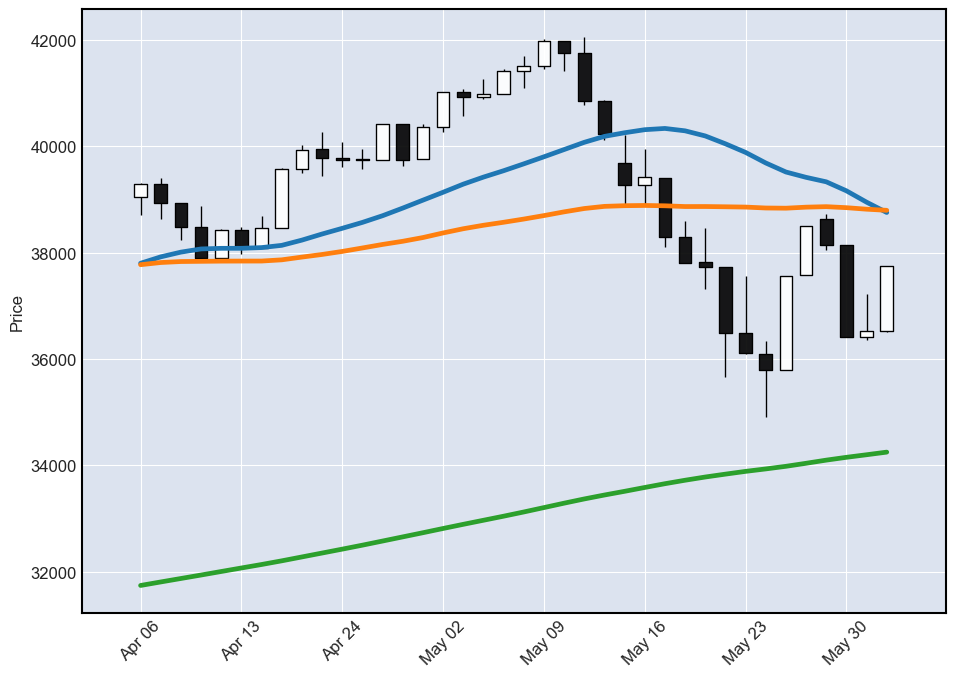

In [10]:
data_init = df_results.index[0]
data_final = df_results['data_sai'].iloc[0]
df_plot = df.loc[data_init:data_final]
plot_mm_rapida = mpf.make_addplot(df_plot['Media_rapida'])
plot_mm_lenta = mpf.make_addplot(df_plot['Media_lenta'])
plot_mm_filtro = mpf.make_addplot(df_plot['mm_filtro'])
mpf.plot(df_plot, type='candle', addplot=[plot_mm_rapida, plot_mm_lenta, plot_mm_filtro], figscale=1.5)

## **6. Resultados**

### ***6.1 Resultado Acumulado***

<Axes: xlabel='data_ent'>

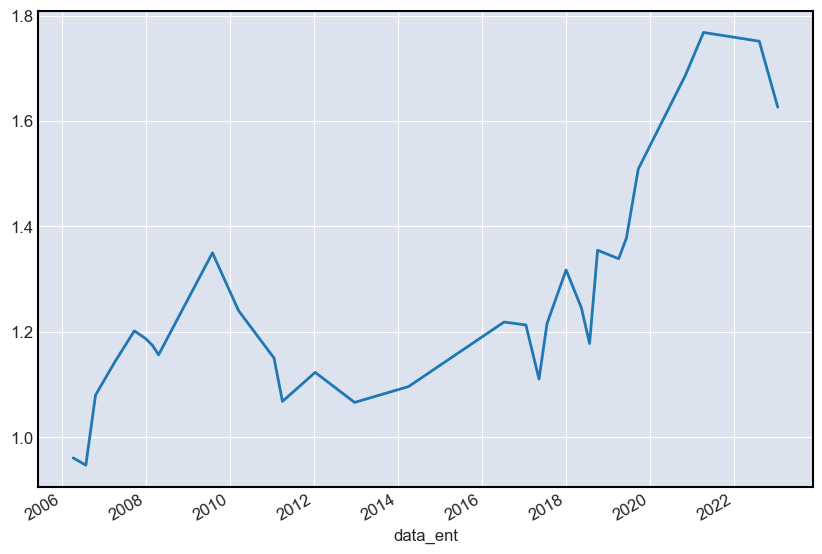

In [19]:
df_results['com filtro mm200'].cumprod().plot(figsize=(10,7))

### ***6.2 Comparação com cruzamento sem filtro do indicador***

<Axes: xlabel='data_ent'>

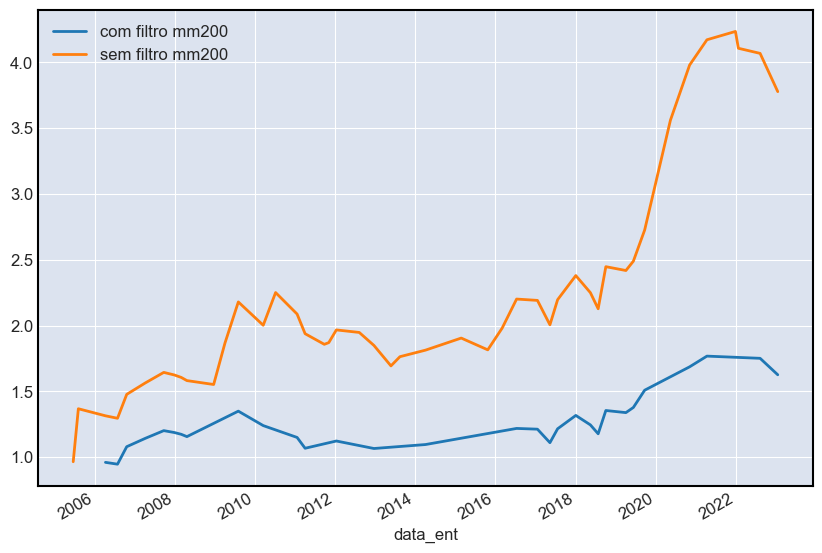

In [20]:
position = 0
dict_precos = {'entrada':[], 'data_ent':[], 'preco_ent':[], 'saida':[], 'data_sai':[], 'preco_sai':[]}

for i in range(len(df)):

    if (position==0) and (df['Media_rapida'].iloc[i] > df['Media_lenta'].iloc[i]) and (df['Media_rapida'].shift(1).iloc[i] < df['Media_lenta'].shift(1).iloc[i]):
        dict_precos['entrada'].append('compra')
        dict_precos['data_ent'].append(df.index[i])
        dict_precos['preco_ent'].append(df.Close[i])
        position=1

    if (position==1) and (df['Media_rapida'].iloc[i] < df['Media_lenta'].iloc[i]) and (df['Media_rapida'].shift(1).iloc[i] > df['Media_lenta'].shift(1).iloc[i]):
        dict_precos['saida'].append('realiza')
        dict_precos['data_sai'].append(df.index[i])
        dict_precos['preco_sai'].append(df.Close[i])
        position=0
        
df_results_sem_ind = pd.DataFrame.from_dict(dict_precos, orient='index').transpose()
df_results_sem_ind = df_results_sem_ind.set_index('data_ent')
df_results_sem_ind['sem filtro mm200'] = (df_results_sem_ind.preco_sai/df_results_sem_ind.preco_ent)

df_results['com filtro mm200'].cumprod().plot(legend=True, figsize=(10,7))
df_results_sem_ind['sem filtro mm200'].cumprod().plot(legend=True, figsize=(10,7))

In [ ]:
pd.merge(df_results, df_results_sem_ind, how='right', left_index=True, right_index=True)